# Tutorial: Fit binary model to observed data with emcee

In this tutorial we go through the procedure of fitting observations to a binary star model using the sampling code [emcee](https://emcee.readthedocs.io/).

## Imports and Filter Setup

In [1]:
from phitter import observables, filters
from phitter.params import star_params, binary_params, isoc_interp_params
from phitter.calc import model_obs_calc, phot_adj_calc, rv_adj_calc
from phitter.fit import likelihood, prior

import numpy as np

from phoebe import u
from phoebe import c as const
import matplotlib as mpl
import matplotlib.pyplot as plt

import pickle
from astropy.table import Table

import emcee
import corner
from multiprocessing import Pool

%matplotlib inline

# The following warning regarding extinction originates from SPISEA and can be ignored.
# The functionality being warned about is not used by SPISEA.

/Users/abhimat/Software/miniforge3/envs/phoebe_py38/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Volumes/Noh/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
filter_153m = filters.hst_f153m_filt()
filter_127m = filters.hst_f127m_filt()

## Prepare observations data

Let's read in the mock data generated in a [separate example here](create_mock_data). Let's assume this data is for a red giant binary star belonging to an 8 Gyr old star population at the Galactic center.

In [3]:
with open('./mock_obs_table.pkl', 'rb') as in_file:
    obs_table = pickle.load(in_file)

print(obs_table)

    obs_times             obs         obs_uncs obs_types                       obs_filts                       
------------------ ------------------ -------- --------- ------------------------------------------------------
53800.714762925796 16.769110541124228    0.015      phot <phitter.filters.hst_f153m_filt object at 0x104bc4040>
 53802.78887450278 16.569960382011555    0.015      phot <phitter.filters.hst_f153m_filt object at 0x104bc4040>
 53804.08607971392 16.523859319835843    0.015      phot <phitter.filters.hst_f153m_filt object at 0x104bc4040>
 53804.64136070461  16.54425287095397    0.015      phot <phitter.filters.hst_f153m_filt object at 0x104bc4040>
53805.203583377115 16.551835703948942    0.015      phot <phitter.filters.hst_f153m_filt object at 0x104bc4040>
 53805.96328097839 16.559083907180494    0.015      phot <phitter.filters.hst_f153m_filt object at 0x104bc4040>
53806.315847597616 16.526208341236522    0.015      phot <phitter.filters.hst_f153m_filt object at 0x104

We create two new {py:obj}`phitter.observables` objects, one for modeling containing only the times, filters, and types of observations, and another for computing the likelihood, which will also contain the observations and associated uncertainties as well.

In [4]:
# Model observables object, which only contains times and types of observations
model_observables = observables.observables(
    obs_times=obs_table['obs_times'].data,
    obs_filts=obs_table['obs_filts'].data, obs_types=obs_table['obs_types'].data,
)

# An observables object for the observations, used when computing likelihoods
observations = observables.observables(
    obs_times=obs_table['obs_times'].data, obs=obs_table['obs'].data, obs_uncs=obs_table['obs_uncs'].data,
    obs_filts=obs_table['obs_filts'].data, obs_types=obs_table['obs_types'].data,
)

## Make stellar parameters and binary parameters objects for fitting

Now we can make a stellar parameters object that we will use to derive the stellar parameters from an isochrone while fitting. Let's use our previous assumptions about what type of star this is: red giant in an 8 Gyr old star population.

We also can create a binary parameters object that will store the binary parameters.

In [5]:
isoc_stellar_params_obj = isoc_interp_params.isoc_mist_stellar_params(
    age=8e9,
    met=0.0,
    use_atm_func='merged',
    phase='RGB',
    ext_Ks=2.2,
    dist=8e3*u.pc,
    filts_list=[filter_153m, filter_127m],
    ext_law='NL18',
)

# Make binary params objects
bin_params = binary_params.binary_params()

## Set up model and likelihood objects

In order to carry out our fitting, we will generate two more objects: a model object that will be used to compute observables and a likelihood object that will compute the likelihood from our observations.

In [6]:
# Set up a binary model object
binary_model_obj = model_obs_calc.binary_star_model_obs(
    model_observables,
    use_blackbody_atm=False,
    print_diagnostics=False,
)

# Set up likelihood object for fitting parameters
log_like_obj = likelihood.log_likelihood_chisq(
    observations
)

## Set up log likelihood, log prior, and log probability functions for emcee

Now we need to write a function that will be used by emcee to calculate the log likelihood for a given set of fit parameters.

For our fitting, we'll fit our data to eight parameters:
1. radius of star 1
2. radius of star 2
3. binary orbital period
4. binary inclination
5. system t0
6. binary CoM velocity
7. extinction in F153M passband
8. extinction law alpha

In [7]:
def emcee_log_like(model_params):
    (
        star1_radius,
        star2_radius,
        bin_period,
        bin_inc,
        bin_t0,
        bin_rv_com,
        ext_153m,
        ext_alpha,
    ) = model_params
    
    # Obtain stellar params by interpolating along the isochrone
    star1_params = isoc_stellar_params_obj.interp_star_params_rad(
        star1_radius,
    )
    star2_params = isoc_stellar_params_obj.interp_star_params_rad(
        star2_radius,
    )
    
    # Set binary params
    bin_params.period = bin_period * u.d
    bin_params.inc = bin_inc * u.deg
    bin_params.t0 = bin_t0
    
    # Run binary model
    modeled_observables = binary_model_obj.compute_obs(
        star1_params, star2_params, bin_params,
        num_triangles=300,
    )
    
    # Check for situation where binary model fails
    # (i.e., unphysical conditions not able to be modeled)
    if np.isnan(modeled_observables.obs_times[0]):
        return -np.inf
    
    # Apply distance modulus
    # (We're assuming we know the distance, but this can be a fit parameter as well)
    modeled_observables = phot_adj_calc.apply_distance_modulus(
        modeled_observables,
        7.971e3*u.pc,
    )
    
    # Apply extinction
    modeled_observables = phot_adj_calc.apply_extinction(
        modeled_observables,
        2.2, filter_153m,
        ext_153m,
        isoc_red_law='NL18',
        ext_alpha=ext_alpha,
    )
    
    # Add RV center of mass velocity
    modeled_observables = rv_adj_calc.apply_com_velocity(
        modeled_observables,
        bin_rv_com * u.km / u.s,
    )
    
    # Compute and return log likelihood
    log_like = log_like_obj.evaluate(modeled_observables)
    
    return log_like


We also need a function for the log prior and a log prob function for emcee. We can create them in the following way:

In [8]:
def emcee_log_prior(model_params):
    (
        star1_radius,
        star2_radius,
        bin_period,
        bin_inc,
        bin_t0,
        bin_rv_com,
        ext_153m,
        ext_alpha,
    ) = model_params
    
    s1_checks = 10.0 < star1_radius < 25.0
    
    s2_checks = 8.0 < star2_radius < 15.0
    
    bin_param_checks = 22.0 < bin_period < 28.0 and\
        40.0 < bin_inc < 140.0 and\
        53_795.0 < bin_t0 < 53_805.0 and\
        100.0 < bin_rv_com < 200.0
    
    ext_checks = 4.0 < ext_153m < 6.0 and\
        2.17 < ext_alpha < 2.29
    
    if s1_checks and s2_checks and bin_param_checks and ext_checks:
        log_prior = 0.0
        
        return log_prior
    else:
        return -np.inf

def emcee_log_prob(model_params):
    lp = emcee_log_prior(model_params)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + emcee_log_like(model_params)

Let's test out our `emcee_log_prob()` function on some mock binary parameters

In [9]:
test_params = (
    18., 10.,
    23., 85.,
    53_801.,
    140.,
    4.4, 2.22,
)

log_like_test = emcee_log_prob(test_params)

print(f'log prob from test parameters = {log_like_test:.3f}')

# Since we simulated these mock data ourselves, we know what the "truth" is here. So we can check that as well
truth_params = (
    15., 12.,
    25., 75.,
    53_800.,
    150.,
    4.5, 2.23,
)

log_like_truth = emcee_log_prob(truth_params)

print(f'log prob from "truth" parameters = {log_like_truth:.3f}')

log prob from test parameters = -42081.556
log prob from "truth" parameters = -41.971


## Initialize walker positions

Before we start sampling with emcee, we need to initialize the walker's starting positions (e.g., see [this emcee tutorial](https://emcee.readthedocs.io/en/stable/tutorials/line/)). We can make a "Gaussian ball" around an initial rough guess (which I've intentionally made slightly different from the "truth"!).

In [10]:
n_params = len(test_params)
n_walkers = n_params * 10

p0 = [(
    14 + 1.e0 * np.random.randn(),
    11 + 1.e0 * np.random.randn(),
    24 + 1.e0 * np.random.randn(),
    90. + ((10 + 5e0*np.random.randn()) * np.sign(np.random.rand() - 0.5)),
    53_801 + 1.e0 * np.random.randn(),
    140. + 5.e0 * np.random.randn(),
    4.4 + 1.e-1 * np.random.randn(),
    2.22 + 1.e-2 * np.random.randn(),
) for i in range(n_walkers)]

# Check a few starting samples to see where parameters are
print(p0[0])
print(p0[2])
print(p0[4])
print(p0[6])
print(p0[8])
print(p0[10])

(14.47892920724483, 11.276727701200546, 25.217452017965808, 103.48342064481523, 53800.58894731225, 137.02612844948186, 4.503419215975494, 2.224099784191553)
(12.716566273109867, 10.06382840081517, 23.69835325196324, 101.22917370641278, 53797.90622013221, 141.03897907531967, 4.421230462762748, 2.2173935687465214)
(14.418872392083427, 10.793388043866987, 24.232174875833678, 101.69675576674705, 53801.16558560297, 137.18622203662952, 4.3339440786974, 2.2351612537495344)
(14.010365967329573, 11.423554414138437, 24.002556052040834, 90.51884083668568, 53801.5536072747, 142.75122324998884, 4.509535921168592, 2.202097777445174)
(14.821334119595459, 11.109939992296658, 24.8031140555109, 78.10172166175022, 53800.46863926781, 141.68317432837793, 4.324163346702092, 2.2204467623463158)
(13.534212852292521, 11.688743768651523, 23.257138599160733, 76.30425529906718, 53801.220011747835, 132.05311728831578, 4.354545784329817, 2.2140482543352538)


## Run emcee sampler

The syntax below shows how to run the sampler. However for speed, I wrote a [separate script](fit_with_emcee.py) that can be parallelized with Python multiprocessing.

emcee can resume from previous runs and the code block below can pick up on the samples from the separate parallelized script.

In [11]:
n_steps=1000

# Set up backend to save run
filename = 'emcee_chains.h5'
backend = emcee.backends.HDFBackend(filename)

# Set up sampler
sampler = emcee.EnsembleSampler(
    n_walkers, n_params, emcee_log_prob,
    backend=backend, 
)

# Determine number of steps completed so far
n_steps=500
n_steps_completed = backend.iteration
n_steps_remaining = n_steps - n_steps_completed

if n_steps_completed == 0:
    sampler.run_mcmc(p0, n_steps_remaining, progress=True)
elif n_steps_remaining > 0:
    sampler.run_mcmc(None, n_steps_remaining, progress=True)


## Examine the fit results

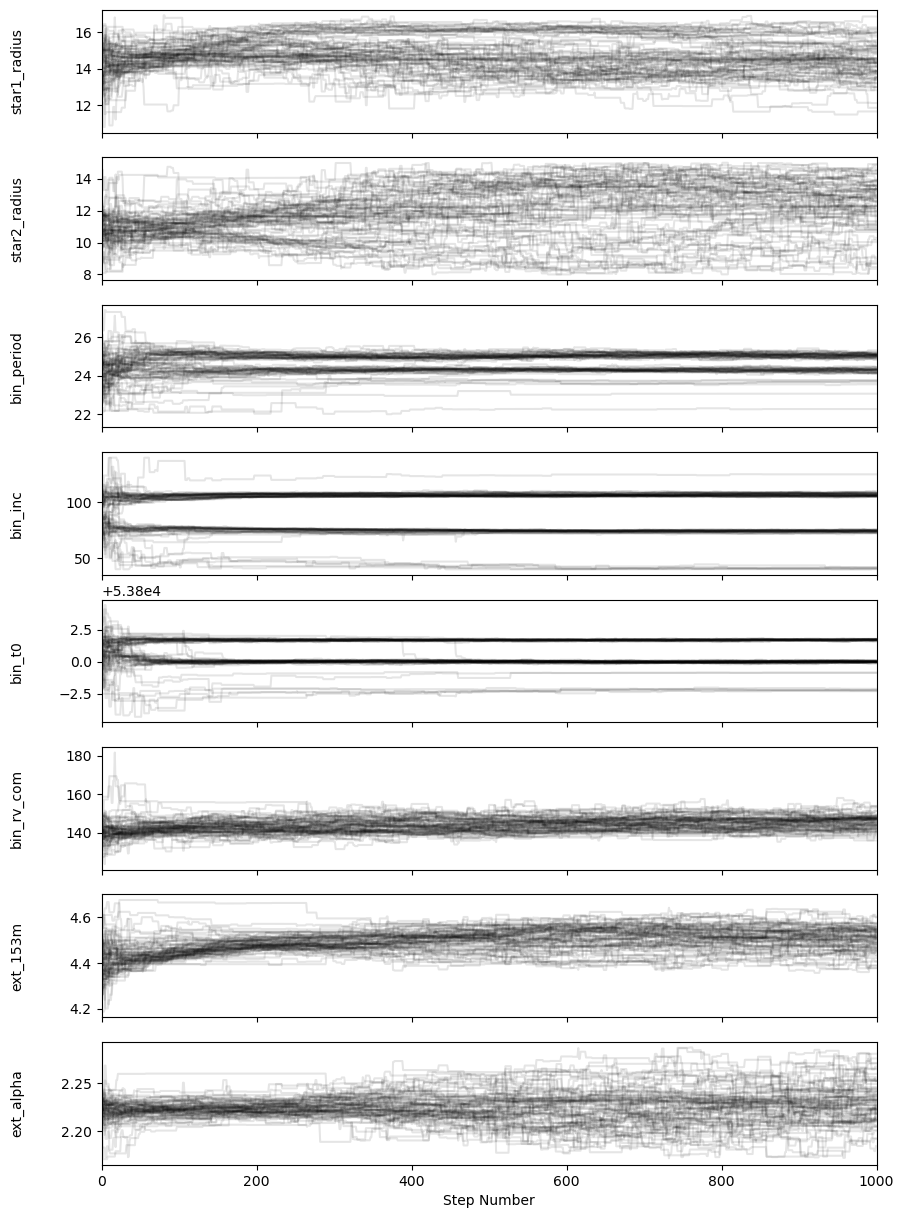

In [12]:
fig, axes = plt.subplots(n_params, figsize=(10, 15), sharex=True)
samples = sampler.get_chain()
labels = [
    'star1_radius',
    'star2_radius',
    'bin_period',
    'bin_inc',
    'bin_t0',
    'bin_rv_com',
    'ext_153m',
    'ext_alpha',
]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step Number");

Compute an autocorrelation time to estimate number of steps to discard for burn-in and how many steps to "thin" the chains by.

Ideally we should run the sampler longer, but we will ignore the warning for this tutorial! 😅

In [13]:
tau = sampler.get_autocorr_time(quiet=True)
print(f"tau: {tau}")

discard = int(np.floor(np.max(tau) * 2))
thin = int(np.ceil(np.max(tau) / 2))

print(f"Number of steps to discard for burn-in: {discard}")
print(f"Number of steps for thinning chains: {thin}")

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 95.00843434 111.54112011  85.9615038   81.58055751  59.77598562
  97.63162579 106.75346184  97.26613673]


tau: [ 95.00843434 111.54112011  85.9615038   81.58055751  59.77598562
  97.63162579 106.75346184  97.26613673]
Number of steps to discard for burn-in: 223
Number of steps for thinning chains: 56


In [14]:
flat_samples = sampler.get_chain(discard=discard, thin=thin, flat=True)
print(flat_samples.shape)

(1040, 8)


We can make a corner plot to compare our estimates for each parameter. We'll also put in the "truth" values in here (shown as blue lines), corresponding to the value of each parameter with which we generated the mock data.

The fit recovers the generated parameters. Interestingly, the solution appears to be multimodal: in particular, there are other values for the period or stellar radii than the "truth" which appear to give plausible solutions!

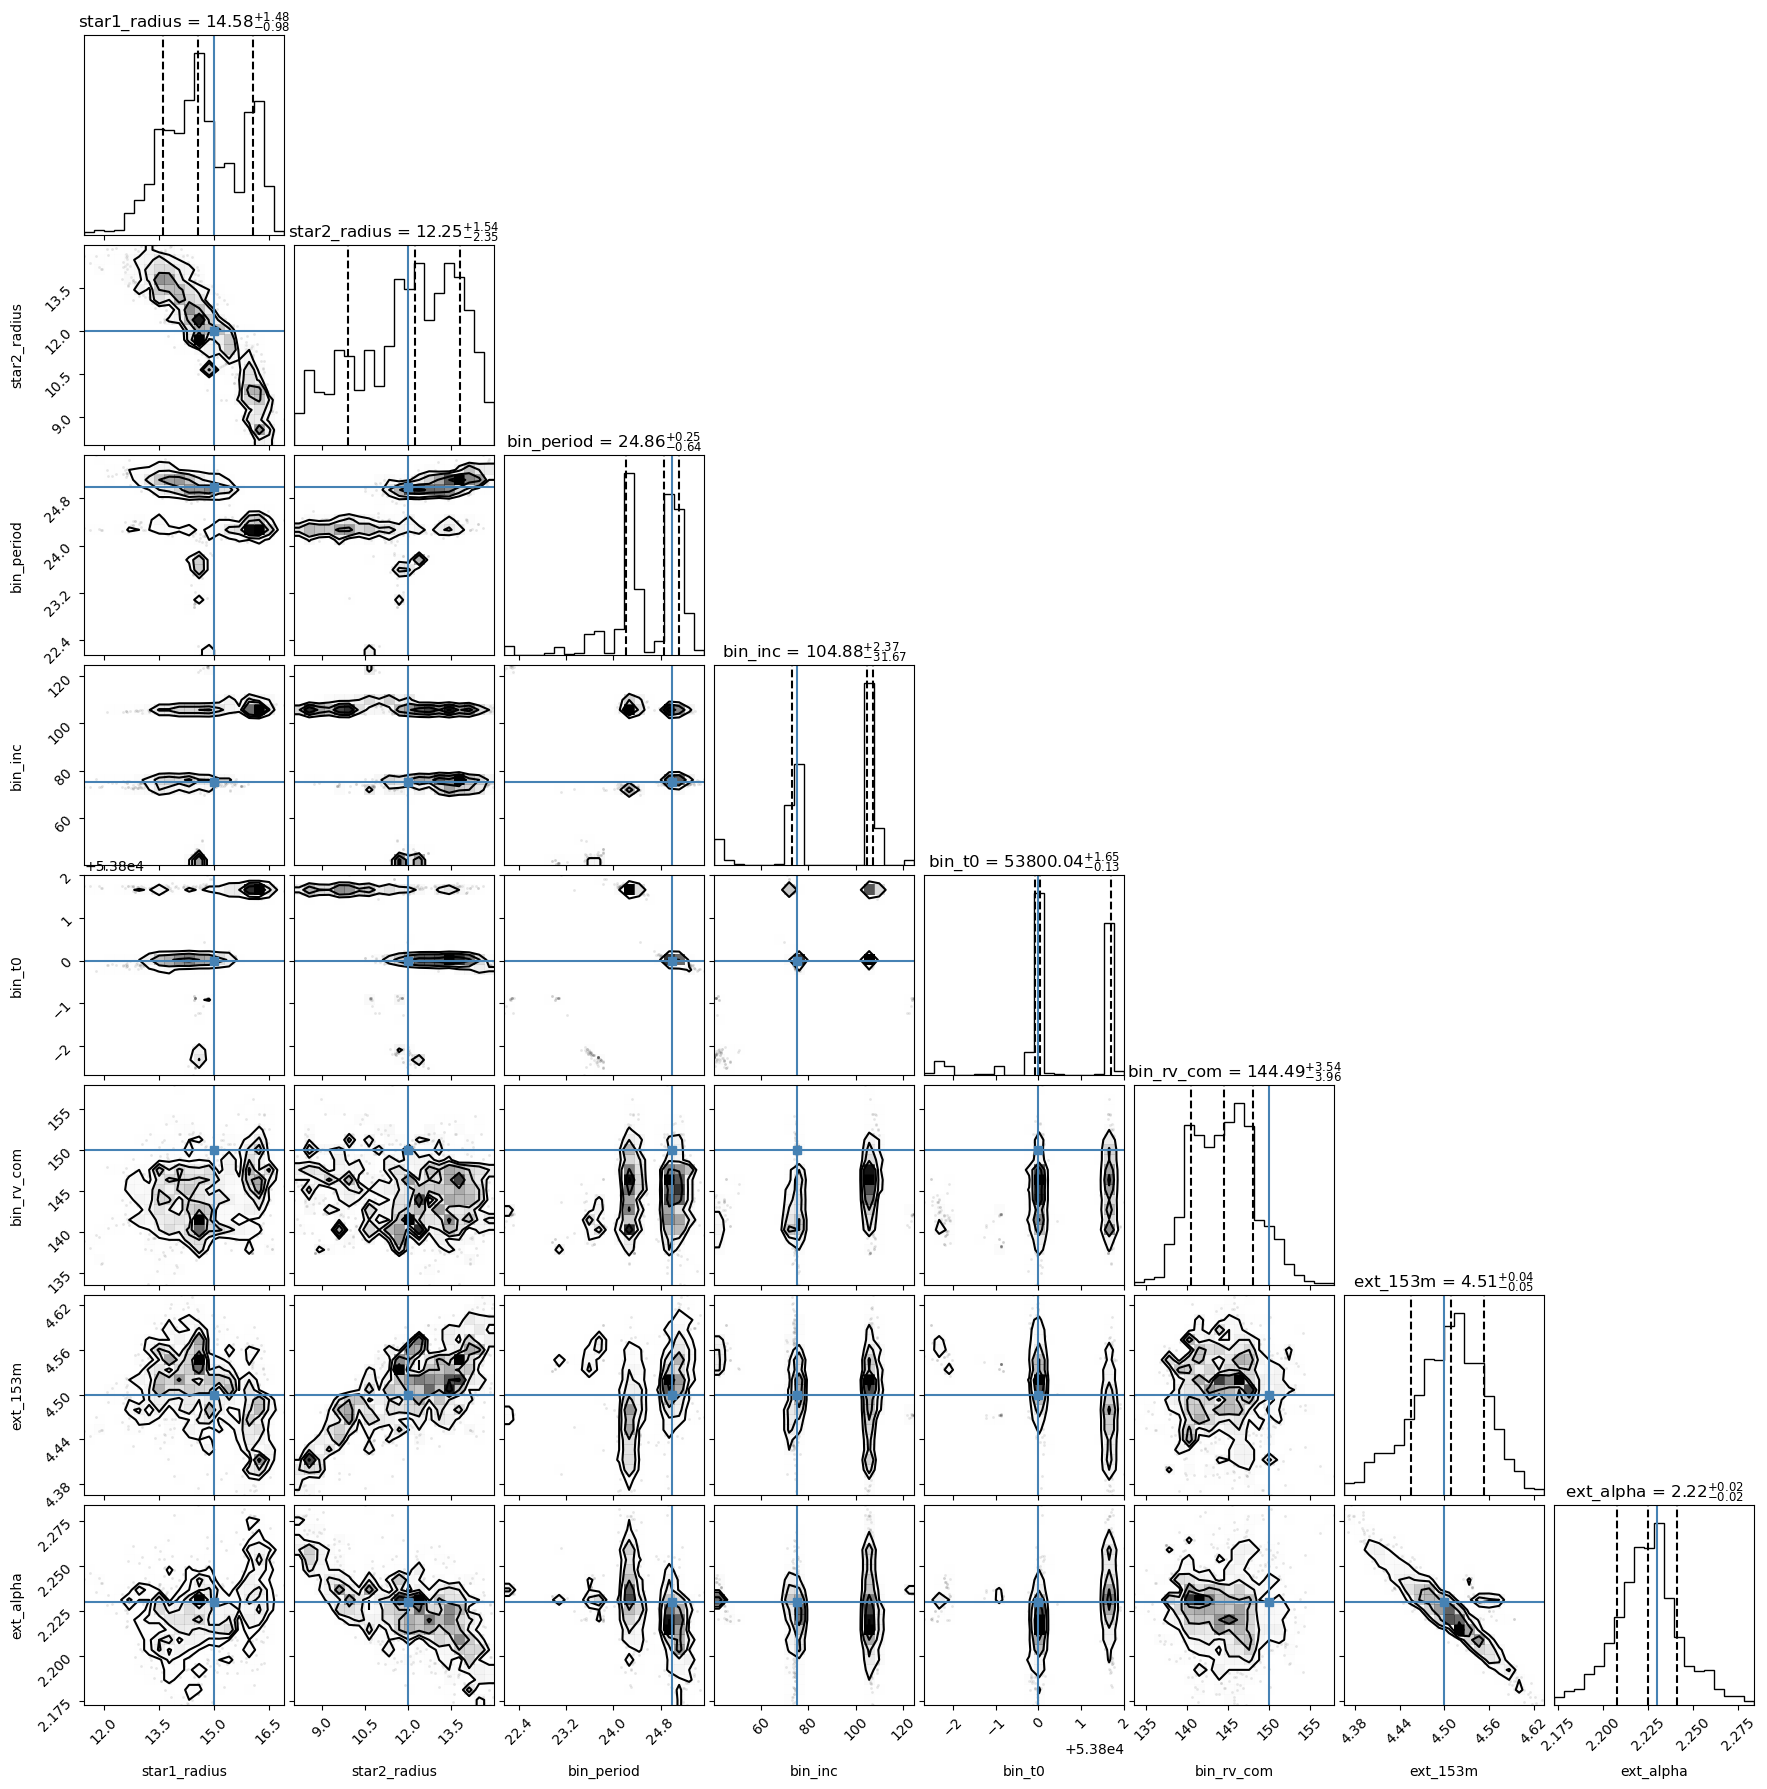

In [15]:
fig = corner.corner(
    flat_samples, labels=labels, truths=truth_params,
    quantiles=[0.15866, 0.5, 0.8413],
    show_titles=True,
)